In [9]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,LogisticRegression
test = pd.read_csv('zhengqi_test.txt','\t')
train = pd.read_csv('zhengqi_train.txt','\t')

In [10]:
#load_dataset
with open("./zhengqi_train.txt")  as fr:
    data_train=pd.read_table(fr,sep="\t")
with open("./zhengqi_test.txt") as fr_test:
    data_test=pd.read_table(fr_test,sep="\t")


In [11]:
#merge train_set and test_set
data_train["oringin"]="train"
data_test["oringin"]="test"
data_all=pd.concat([data_train,data_test],axis=0,ignore_index=True)

data_all.drop(["V5","V9","V11","V17","V22","V28"],axis=1,inplace=True)

In [12]:
# normalise numeric columns
cols_numeric=list(data_all.columns)
cols_numeric.remove("oringin")
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())
scale_cols = [col for col in cols_numeric if col!='target']
data_all[scale_cols] = data_all[scale_cols].apply(scale_minmax,axis=0)

In [13]:

# Check effect of Box-Cox transforms on distributions of continuous variables

fcols = 6
frows = len(cols_numeric) - 1
plt.figure(figsize=(4 * fcols, 4 * frows))
i = 0


<Figure size 2400x12800 with 0 Axes>

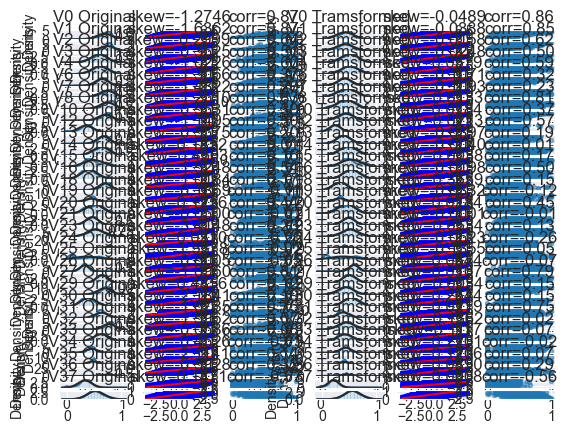

count    2888.000000
mean        0.126353
std         0.983966
min        -3.044000
25%        -0.350250
50%         0.313000
75%         0.793250
max         2.538000
Name: target, dtype: float64


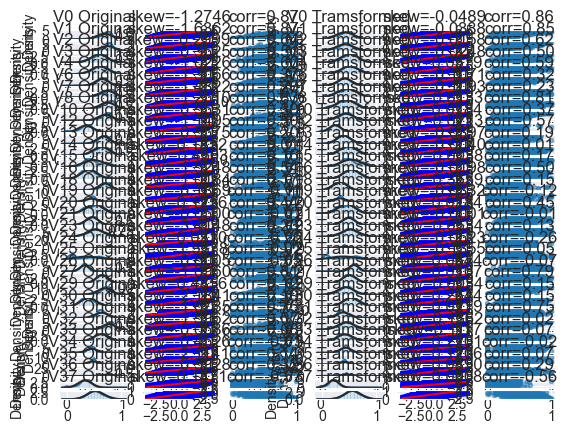

In [14]:
for var in cols_numeric:
    if var != 'target':
        dat = data_all[[var, 'target']].dropna()

        i += 1
        plt.subplot(frows, fcols, i)
        sns.distplot(dat[var], fit=stats.norm);
        plt.title(var + ' Original')
        plt.xlabel('')


        i += 1
        plt.subplot(frows, fcols, i)
        _ = stats.probplot(dat[var], plot=plt)
        plt.title('skew=' + '{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')

        i += 1
        plt.subplot(frows, fcols, i)
        plt.plot(dat[var], dat['target'], '.', alpha=0.5)
        plt.title('corr=' + '{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))

        i += 1
        plt.subplot(frows, fcols, i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna() + 1)
        trans_var = scale_minmax(trans_var)
        sns.distplot(trans_var, fit=stats.norm);
        plt.title(var + ' Tramsformed')
        plt.xlabel('')

        i += 1
        plt.subplot(frows, fcols, i)
        _ = stats.probplot(trans_var, plot=plt)
        plt.title('skew=' + '{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')

        i += 1
        plt.subplot(frows, fcols, i)
        plt.plot(trans_var, dat['target'], '.', alpha=0.5)
        plt.title('corr=' + '{:.2f}'.format(np.corrcoef(trans_var, dat['target'])[0][1]))

cols_transform=data_all.columns[0:-2]
for col in cols_transform:
    # transform column
    data_all.loc[:,col], _ = stats.boxcox(data_all.loc[:,col]+1)

print(data_all.target.describe())

count    2888.000000
mean        1.129957
std         0.394110
min         0.291057
25%         0.867609
50%         1.135315
75%         1.379382
max         2.798463
Name: target, dtype: float64


-2.145287041600652

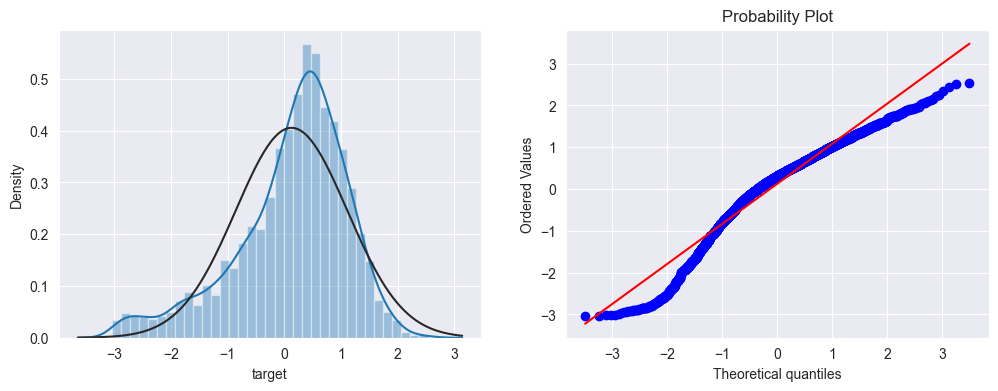

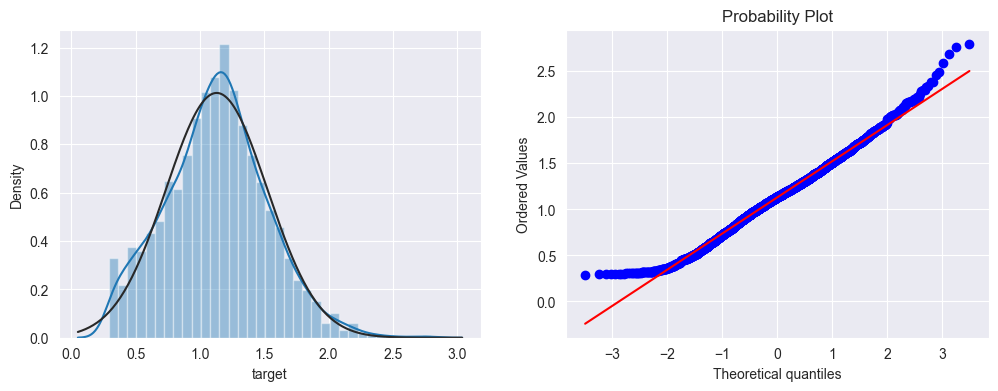

count    2888.000000
mean        1.129957
std         0.394110
min         0.291057
25%         0.867609
50%         1.135315
75%         1.379382
max         2.798463
Name: target, dtype: float64


-2.1589285028751517

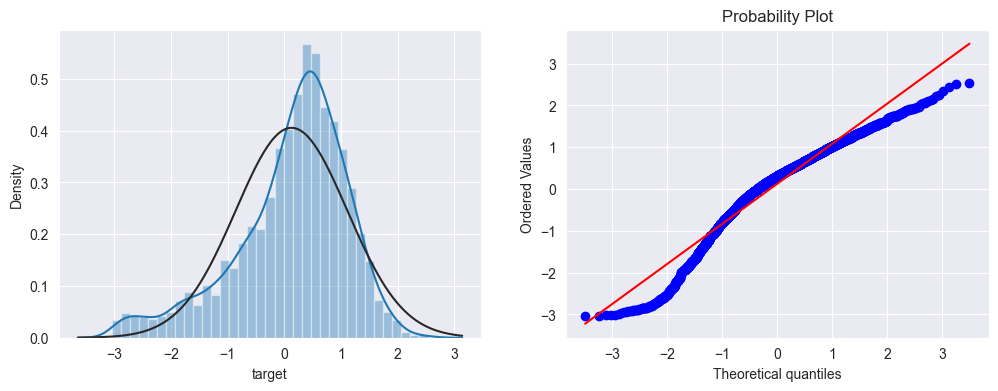

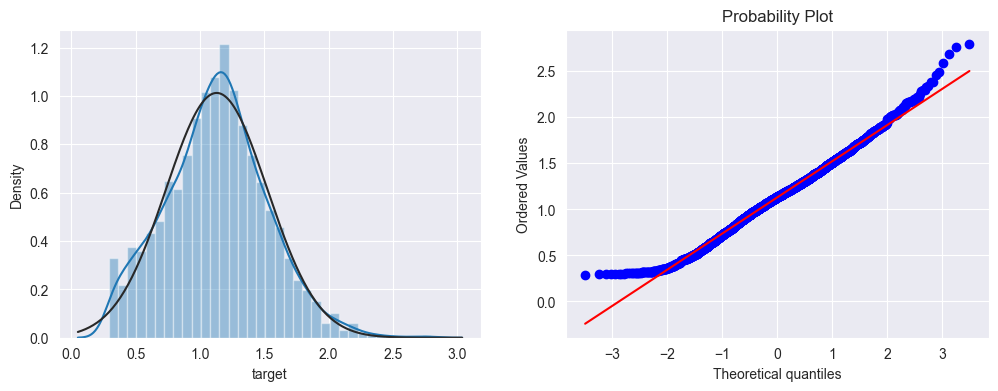

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_all.target.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_all.target.dropna(), plot=plt)

#Log Transform SalePrice to improve normality
sp = data_train.target
data_train.target1 =np.power(1.5,sp)
print(data_train.target1.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_train.target1.dropna(),fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_train.target1.dropna(), plot=plt)

train.shape
X_train =  train.iloc[:,0:38]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,0:38]
y_test = test.iloc[:,-1]

ada = AdaBoostRegressor(n_estimators=100,learning_rate=0.01,loss='exponential')
ada.fit(X_train,y_train)
ada.predict(X_test)
ada.score(X_test,y_test)

In [16]:

estimators = {}
estimators['ada'] = AdaBoostRegressor(n_estimators=100)
estimators['forest'] = RandomForestRegressor(n_estimators=100)
estimators['extra'] = ExtraTreesRegressor(n_estimators=100)
estimators['gbr'] = GradientBoostingRegressor(n_estimators=100)
estimators['linear'] = LinearRegression()
# estimators['logis']  = LogisticRegression()

pca  = PCA(n_components=17,whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

X_train_pca.shape

# estimators.items()
from sklearn.metrics import mean_squared_error
for key,model in estimators.items():
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    y_ = model.predict(X_test)
    mse = mean_squared_error(y_test,y_)
    print(key,score,mse)

# estimators.items()
from sklearn.metrics import mean_squared_error
for key,model in estimators.items():
    model.fit(X_train_pca,y_train)
    score = model.score(X_test_pca,y_test)
    y_ = model.predict(X_test_pca)
    mse = mean_squared_error(y_test,y_)
    print(key,score,mse)

ada = estimators['ada']
s = ada.predict(X_test_pca)
s = pd.DataFrame(s)
s.to_csv('result.txt')
np.savetxt('result.txt',s)

ada -2.098620169333173 2.7400060898466405
forest -2.214323853634912 2.8423189847093506
extra -2.184963553601629 2.8163566542220257
gbr -2.266256084320937 2.8882409178805437
linear -6.627197780135935 6.744475677551224
ada -1.3049626792726512 2.038201338964182
forest -1.6366954006790366 2.3315414797954808
extra -1.6180333964289817 2.315039294145247
gbr -1.565930157825607 2.2689661443972087
linear -1.5688971690116724 2.2715897730687447
ada -2.0756239589373147 2.7196713107886428
forest -2.224188768840114 2.8510421989985972
extra -2.2054945032037723 2.834511485684416
gbr -2.2658281655848387 2.8878625236667346
linear -6.627197780135935 6.744475677551224
ada -1.316223078175557 2.0481585327736784
forest -1.6184248838432858 2.315385473360727
extra -1.6205671769170498 2.3172798314128835
gbr -1.571100322835349 2.273537948244743
linear -1.5687959211466485 2.2715002429709625
